In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem
import os

#%% Plot Tong's default setting
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels"
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

'''
colorWheel =['#329932', '#ff6961', 'b', '#6a3d9a', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
            '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#67001f', '#b2182b', '#d6604d', 
            '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
dashesStyles = [[3,1],
            [1000,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1]]
'''
NUMOFAGENTS = 46850
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_list2 = ['#070707', '#ff3b3b'] # ['#81b8df', '#fe817d']
color_list3 = ['#4d85bd', '#f7913d', '#59a95a'] # ['#d22026', '#385889', '#7fa5b7']
color_list4 = ['#2d3063', '#6dab7a', '#d4357a', '#e3ab12']
color_list5 = ['#015699', '#fabf0f', '#f3774a', '#5fc5c9', '#15ab30']#['#015699', '#fabf0f', '#f3774a', '#5fc5c9', '#4f596d']
 

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims

'''
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

axes.set_xlabel("")
axes.set_title('')

fig.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig.savefig("./figures/XXX.png", dpi=300)
'''

'\nfig_dims = figure_size_setting(700)\nfig_dims = [fig_dims[0], fig_dims[1]*1]\nfig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)\n\naxes.set_xlabel("")\naxes.set_title(\'\')\n\nfig.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)\nfig.savefig("./figures/XXX.png", dpi=300)\n'

## Simulation of SDE (Stochastic Differential Equation)
The SDE for the susceptibility $\alpha$ is $\dot{\alpha_i} = -\frac{\alpha_i - \bar{\alpha_i}}{\tau} + \eta_i(t)$, where $\eta_i(t)$ is the short-time noise that follows $\eta_i(t)\eta_i(t^\prime) = \frac{2\alpha_i(t)}{\tau k_0}\delta(t-t^\prime)$. The following numerical simulation adopts the Euler-Maruyama method.

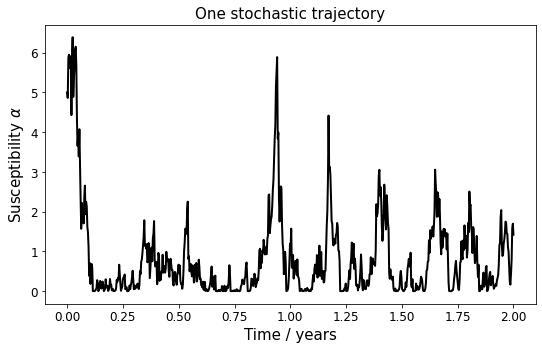

In [2]:
sigma = 0.  # Standard deviation.
k0 = 0.4 #0.2 # dispersion parameter
mu = 1.  # Mean.
tau = 30/365 #150/365  # rewiring time constant (in years)

gamma = 365. / 5 # inverse of infectious period duration
dt = 1.0/365#2.5/365#5.0/365#2.5/365 #0.002 #.002 #.0001  # Time step.
T = 2.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

sigma_bis = np.sqrt(2. / tau / k0)
sqrtdt = np.sqrt(dt)

x = np.zeros(n)
x[0] = 5

for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + \
        sigma_bis * np.sqrt(np.maximum(x[i], 0)) * sqrtdt * np.random.randn()

fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims)
x_nonzero = x.copy()
x_nonzero[x_nonzero<0] = 0
axes.plot(t, x_nonzero, lw=2, color='black')
axes.set_xlabel('Time / years')
axes.set_ylabel("Susceptibility $\\alpha$")
axes.set_title('One stochastic trajectory')
fig.subplots_adjust(left=.09, bottom=.12, right=.97, top=.93, hspace=0.1)
fig.savefig("./figures/one_stochastic_trajectory_SDE.png", dpi=300)

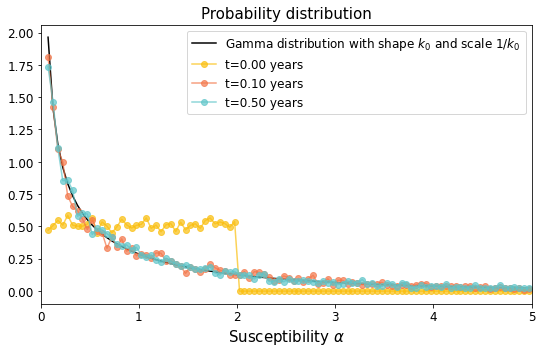

In [3]:
ntrials = 10000
X = np.random.uniform(low=0.0, high=2.0, size=ntrials)
# We create bins for the histograms.
bins = np.linspace(0.05, 5., 100)
vis_bins = (bins[1:] + bins[:-1]) / 2
bin_width = (vis_bins[-1]-vis_bins[0]) / (vis_bins.shape[0]-1)
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims)

from scipy.stats import gamma as gamma_dist
a = k0
rv = gamma_dist(a, loc=0, scale=1/a)
axes.plot(vis_bins, rv.pdf(vis_bins)/np.sum(rv.pdf(vis_bins))/bin_width, 'k-', lw=1.5, label='Gamma distribution with shape $k_0$ and scale $1/k_0$')

X_total = np.zeros((ntrials, n))
for i in range(n):
    # We display the probability distribution (normalized histogram) for a few points in time
    if i in (0, int(0.1/dt), int(0.5/dt)):
        X_nonzero = X.copy()
        X_nonzero[X_nonzero<=0] = 0
        hist, _ = np.histogram(X_nonzero, bins=bins)
        axes.plot(vis_bins, hist/np.sum(hist)/bin_width,
        #axes.plot(vis_bins, hist/np.sum(hist)*np.sum(rv.pdf(vis_bins)),
                {0: 'o-', int(0.1/dt): 'o-', int(0.5/dt): 'o-', }[i], 
                color=color_list5[np.where(np.array([0,int(0.1/dt),int(0.5/dt)])==i)[0][0]+1],
                label=f"t={i * dt:.2f} years", lw=1.5, alpha=0.7)
    # We update the process independently for all trials
    X += dt * (-(X - mu) / tau) + \
        sigma_bis * np.sqrt(np.maximum(X, [0]*X.shape[0])) * sqrtdt * np.random.randn(ntrials)

axes.set_xlim([0, 5])
axes.legend()
axes.set_xlabel("Susceptibility $\\alpha$")
axes.set_title('Probability distribution')
#axes.set_yscale('log')
fig.subplots_adjust(left=.09, bottom=.12, right=.97, top=.93, hspace=0.1)
fig.savefig("./figures/prob_dist_SDE.png", dpi=300)

## Simulation of agent-based SIR (Susceptible, Infectious, or Recovered) Model
The age-of-infection model is $-\frac{1}{S_{\alpha}}\frac{dS_{\alpha}}{dt} = \alpha  J(t)$, where $J(t) = \frac{\gamma R_0 M(t)}{<\alpha^2>}\int_0^{\infty} \alpha I_{\alpha} f_{\alpha} d\alpha$. If we only focus on each individual, then the formula can be rewritten as $-\frac{1}{S_{i}}\frac{dS_{i}}{dt} = \alpha_i J(t)$ and $J(t) = \frac{\gamma R_0 M(t)}{<\alpha^2>} \frac{1}{N_{i}} \sum_i \alpha_i I_{i}$. Note that $S_{i}$ and $I_{i}$ are binary and used to denote if the agent is susceptible or infectious.

In [4]:
#'''
def mitigation_factor_profile_generator(start_day, end_day, mitigation_factor_value):
    mitigation_factor = np.ones(n)
    mitigation_factor[int(start_day/365/dt):int(end_day/365/dt)] = mitigation_factor_value
    '''
    a_series = pd.Series(mitigation_factor)
    rolling_window_obj = a_series.rolling(int(5/365/dt),center=True)
    rolling_average = rolling_window_obj.mean()
    mitigation_factor[int((start_day-2.5)/365/dt):int((end_day+2.5)/365/dt)] = rolling_average[int((start_day-2.5)/365/dt):int((end_day+2.5)/365/dt)].values
    '''
    return mitigation_factor
#'''
'''
def mitigation_factor_profile_generator(start_day, end_day, mitigation_factor_values):
    mitigation_factor = np.ones(n)
    x = np.array(range(int((start_day-5)/365/dt), int((start_day+5)/365/dt)+1))
    increasing_trend = (np.tanh(x-int((start_day)/365/dt))) * (1.0 - mitigation_factor_values) / 2 + (1.0 + mitigation_factor_values) / 2
    mitigation_factor[int((start_day-5)/365/dt):int((end_day+5)/365/dt)+1] = mitigation_factor_values
    mitigation_factor[int((start_day-5)/365/dt):int((start_day+5)/365/dt)+1] = increasing_trend[::-1]
    mitigation_factor[int((end_day-5)/365/dt):int((end_day-5)/365/dt)+x.shape[0]] = increasing_trend
    
    return mitigation_factor
'''

'\ndef mitigation_factor_profile_generator(start_day, end_day, mitigation_factor_values):\n    mitigation_factor = np.ones(n)\n    x = np.array(range(int((start_day-5)/365/dt), int((start_day+5)/365/dt)+1))\n    increasing_trend = (np.tanh(x-int((start_day)/365/dt))) * (1.0 - mitigation_factor_values) / 2 + (1.0 + mitigation_factor_values) / 2\n    mitigation_factor[int((start_day-5)/365/dt):int((end_day+5)/365/dt)+1] = mitigation_factor_values\n    mitigation_factor[int((start_day-5)/365/dt):int((start_day+5)/365/dt)+1] = increasing_trend[::-1]\n    mitigation_factor[int((end_day-5)/365/dt):int((end_day-5)/365/dt)+x.shape[0]] = increasing_trend\n    \n    return mitigation_factor\n'

In [5]:
R0 = 2 # basic reproduction number
k_infinity = 2

def stochastic_SIR(ntrials, mitigation_period, mitigation_factor):
    from scipy.stats import gamma as gamma_dist
    a = k0
    X = gamma_dist.rvs(a, loc=0, scale=1/a, size=ntrials)
    #mu = X.copy()
    a = k_infinity; mu = gamma_dist.rvs(a, loc=0, scale=1/a, size=ntrials)
    #X = np.random.uniform(low=0.0, high=2.0, size=ntrials)
    
    S = np.ones(ntrials)
    I = np.zeros(ntrials)
    R = np.zeros(ntrials)
    N_infectious_init = int(ntrials * 0.001)
    S[:N_infectious_init] = 0; I[:N_infectious_init] = 1
    J = gamma * R0 / np.mean(X**2) * np.dot(X, I) / ntrials

    status_all = np.zeros((6, n))
    for i in range(n):
        i_S = np.where(S==1)[0]
        i_I = np.where(I==1)[0]
        
        X_ori = X.copy()
        # We update the process independently for all trials  
        X += dt * (-(X - mu) / tau) + \
            sigma_bis * np.sqrt(np.maximum(X, [0]*X.shape[0])) * sqrtdt * np.random.randn(ntrials)
        #X[i_I] = X_ori[i_I]
        X_nonzero = X.copy()
        X_nonzero[X_nonzero<=0] = 0
        
        status_all[0, i] = np.sum(S)
        status_all[1, i] = np.sum(I)
        status_all[2, i] = np.sum(R)
        status_all[3, i] = J
        status_all[4, i] = np.mean(X_nonzero[i_S])
        status_all[5, i] = np.mean(X_nonzero[i_I])

        S_temp = S.copy(); I_temp = I.copy(); R_temp = R.copy(); 
        J = gamma * R0 / np.mean(X_nonzero**2) * np.dot(X_nonzero, I) / ntrials
        #if i in mitigation_period:
        #    J = J * mitigation_factor
        J = J * mitigation_factor[i]
        #J = J / (np.mean(mu**2) + 1/k0/(1 + 1 / gamma / tau)) * (np.mean(mu**2) + 1/k0)
        infection_prob = X_nonzero * J * dt 

        i_infected = i_S[np.random.uniform(low=0.0, high=1.0, size=i_S.shape[0]) < infection_prob[i_S]]
        S_temp[i_infected] = 0; I_temp[i_infected] = 1; 
        i_recovered = i_I[np.random.uniform(low=0.0, high=1.0, size=i_I.shape[0]) < gamma * dt]
        I_temp[i_recovered] = 0; R_temp[i_recovered] = 1; 

        S = S_temp; I = I_temp; R = R_temp;
        
    return status_all

In [402]:
ntrials = 1000000 #1000000
NSIM = 3 #10
status_all_multipleSIM = np.zeros((NSIM, 6, n))

start_day = 35
end_day = 80
mitigation_factor = 1.0 #0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)

for count in range(NSIM):
    status_all = stochastic_SIR(ntrials, mitigation_period, mitigation_factor_list)
    status_all_multipleSIM[count, :, :] = status_all

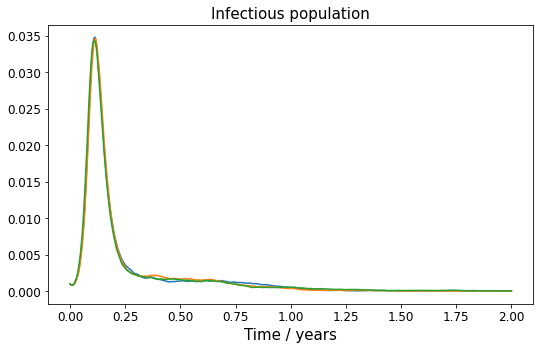

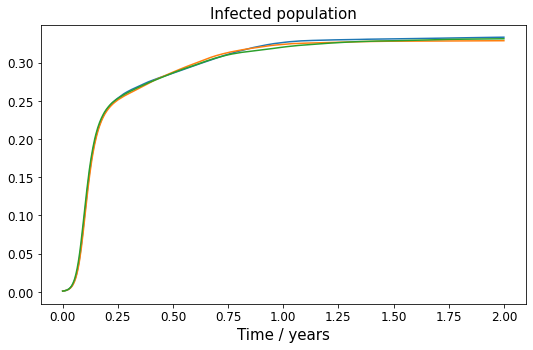

In [403]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

for count in range(NSIM):
    status_all = status_all_multipleSIM[count, :, :]
    axes.plot(t, status_all[1, :] / ntrials)
    axes2.plot(t, (status_all[1, :] + status_all[2, :]) / ntrials)
    
axes.set_xlabel("Time / years")
axes.set_title('Infectious population')
fig.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig.savefig("./figures/multiple_trajectories_of_stochastic_SIR_infectious.png", dpi=300)

axes2.set_xlabel("Time / years")
axes2.set_title('Infected population')
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig2.savefig("./figures/multiple_trajectories_of_stochastic_SIR_infected.png", dpi=300)

## Simulation of the derived soluation from the Fokker-Planck equation
The general equation for the social network rewiring can be written as $\dot{S_{\alpha}}(a,t) = -\alpha S_{\alpha}(a,t) J(t)  + \frac{\alpha}{k_0 \tau}\frac{\partial^2 S_{\alpha}(a,t)}{\partial \alpha^2} + (\frac{\alpha-a}{\tau})\frac{\partial S_{\alpha}(a,t)}{\partial a}$. This equation can be solved by using the following Anzats:

$$S_{\alpha}(a,t) = \text{exp}(-Z(t)\alpha - k_0 h(t) a).$$

Therefore, we have 
$$\dot{h} = \frac{J(t)}{k_0} - \frac{h(1+h)}{\tau},$$
$$\dot{S} = -\frac{J S^{1+\frac{1}{k_{\infty}}}}{1+h},$$
$$\dot{J} = \gamma(R_e(t) - 1)J,$$
where $R_e(t) = \frac{R_0 M(t) S^{\lambda}(t)}{(1+h)^{2}}\frac{1+k_0 \lambda S^{1/k_{\infty}}}{1+k_0 \lambda}$, $\lambda = 1+\frac{1}{k_{\infty}}$, and $S(t) = \text{exp}(-Z - k_0 \text{log}(1+h))$.
For the following simulation, the distribution of activity level $\alpha$ is assumed to be follows the gamma distribution with dispersion parameter $k_{\infty}$.

In [7]:
def Fokker_Planck_SIR(mitigation_period, mitigation_factor):
    h = 0
    N_infectious_init = int(ntrials * 0.001)
    z = 0
    S = 1 - 0.001
    #X = np.random.uniform(low=0.0, high=2.0, size=ntrials)
    from scipy.stats import gamma as gamma_dist
    a = k_infinity; mu = gamma_dist.rvs(a, loc=0, scale=1/a, size=ntrials)
    a = k0
    #X = mu.copy()
    X = gamma_dist.rvs(a, loc=0, scale=1/a, size=ntrials)
    J = gamma * R0 / np.mean(X**2) * N_infectious_init / ntrials
    
    status_all = np.zeros((4, n))
    for i in range(n):
        #print(i, z, S, J)
        status_all[0, i] = 0
        status_all[1, i] = S
        status_all[2, i] = J
        status_all[3, i] = h
        
        mu_g = 1 / (1 + 1 / gamma / tau)
        chi = (1 + 1/k_infinity) / (1 + 1/k_infinity + mu_g/k0)
        lambda_hetero = 1 + (1+chi) / k_infinity #(1+1/k_infinity)
        S_temp = S; h_temp = h; J_temp = J;
        
        h_temp = h + (mitigation_factor[i] * J / k0 - h * (1+h) / tau) * dt;
        #h_temp = h + (mitigation_factor[i] * J / k0/(1 + 1 / gamma / tau) - h * (1+h) / tau) * dt;
        R = R0 * mitigation_factor[i]
        R = R * (np.mean(mu**2) + mu_g/k0) / (np.mean(mu**2) + 1/k0)

        q_chi = (1 - chi + h*(1 - mu_g)) * S**(-chi/k_infinity) + chi * S**((1-chi)/k_infinity)
        #print(q_chi)
        R = R * q_chi * np.exp(dt / tau) # * np.exp(dt / tau) # 1.04
        #S_temp = S - J * S**(1+1/k_infinity) / (1+h) * dt;
        S_temp = S - mitigation_factor[i] * J * S**(1+1/k_infinity) / (1+h) * dt;
        R = R * S**(lambda_hetero) / (1+h)**2 # * (1 + k0 * lambda_hetero * S**(1/k_infinity)) / (1 + k0*lambda_hetero)
        J_temp = J + gamma * (R - 1) * J * dt;

        S = S_temp; h = h_temp; J = J_temp; 
        S = np.abs(S); h = np.abs(h); J = np.abs(J); 
    return status_all

In [14]:
h = 0
N_infectious_init = int(ntrials * 0.001)
z = 0
S = 1 - 0.001
#X = np.random.uniform(low=0.0, high=2.0, size=ntrials)
from scipy.stats import gamma as gamma_dist
a = k_infinity; mu = gamma_dist.rvs(a, loc=0, scale=1/a, size=ntrials)
a = k0
#X = mu.copy()
X = gamma_dist.rvs(a, loc=0, scale=1/a, size=ntrials)
J = gamma * R0 / np.mean(X**2) * N_infectious_init / ntrials

mu_g = 1 / (1 + 1 / gamma / tau)
chi = (1 + 1/k_infinity) / (1 + 1/k_infinity + mu_g/k0)
lambda_hetero = 1 + (1+chi) / k_infinity #(1+1/k_infinity)


#chi = (1 + 1/k_infinity) / (1 + 1/k_infinity + 1/k0)
#lambda_hetero = 1 + (1+chi) / k_infinity #(1+1/k_infinity)

lambda_hetero

1.7058823529411764

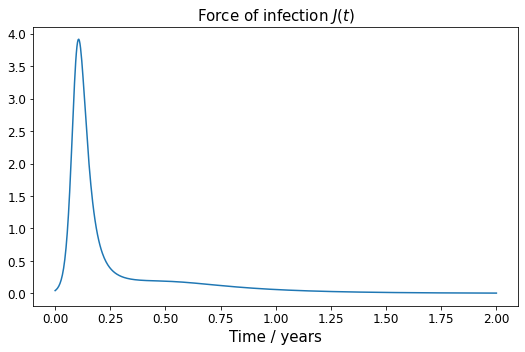

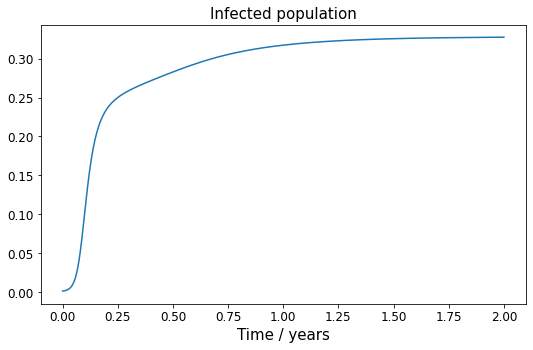

In [408]:
start_day = 35
end_day = 80
mitigation_factor = 1.0 #0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)

status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)

fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

axes.plot(t, status_all[2, :])
axes2.plot(t, (1-status_all[1, :]))
    
axes.set_xlabel("Time / years")
axes.set_title('Force of infection $J(t)$')
fig.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
#fig.savefig("./figures/multiple_trajectories_of_stochastic_SIR_infectious.png", dpi=300)

axes2.set_xlabel("Time / years")
axes2.set_title('Infected population')
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
#fig2.savefig("./figures/multiple_trajectories_of_stochastic_SIR_infected.png", dpi=300)

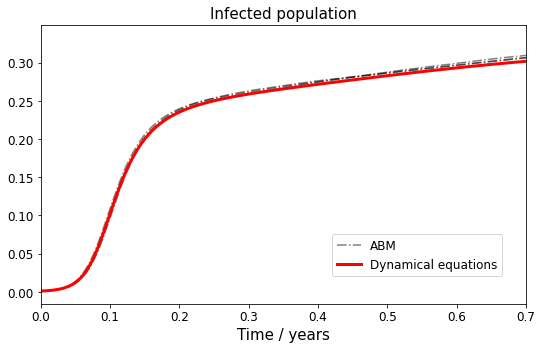

In [416]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

for count in range(NSIM):
    status_all_stochastic = status_all_multipleSIM[count, :, :]
    if count==0:
        axes2.plot(t, (status_all_stochastic[1, :] + status_all_stochastic[2, :]) / ntrials, 'k-.', alpha=0.5, label='ABM')
    else:
        axes2.plot(t, (status_all_stochastic[1, :] + status_all_stochastic[2, :]) / ntrials, 'k-.', alpha=0.5)
axes2.plot(t, (1-status_all[1, :]), 'r-',  lw=3, label='Dynamical equations')

axes2.legend(loc=(0.6, 0.1))
axes2.set_xlabel("Time / years")
axes2.set_title('Infected population')
axes2.set_xlim([0,0.7])
#axes2.set_yscale('log')
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig2.savefig("./figures/comparison_between_stochasticSIR&Fokker-Planck_"+str(mitigation_factor)+"mitigated_infected.png", dpi=300)

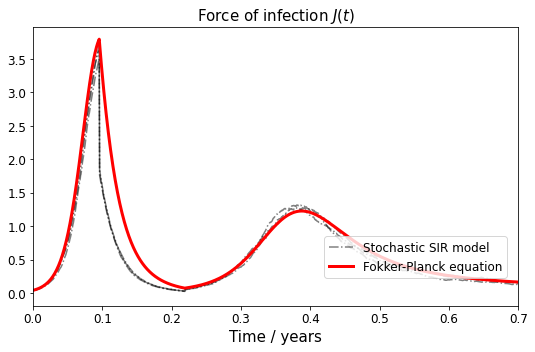

In [378]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

for count in range(NSIM):
    status_all_stochastic = status_all_multipleSIM[count, :, :]
    if count==0:
        axes2.plot(t, status_all_stochastic[3, :], 'k-.', alpha=0.5, label='Stochastic SIR model')
    else:
        axes2.plot(t, status_all_stochastic[3, :], 'k-.', alpha=0.5)
axes2.plot(t, status_all[2, :], 'r-',  lw=3, label='Fokker-Planck equation')

axes2.legend(loc=(0.6, 0.1))
axes2.set_xlabel("Time / years")
axes2.set_title('Force of infection $J(t)$')
axes2.set_xlim([0,0.7])
#axes2.set_yscale('log')
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig2.savefig("./figures/comparison_between_stochasticSIR&Fokker-Planck_"+str(mitigation_factor)+"mitigated_J.png", dpi=300)

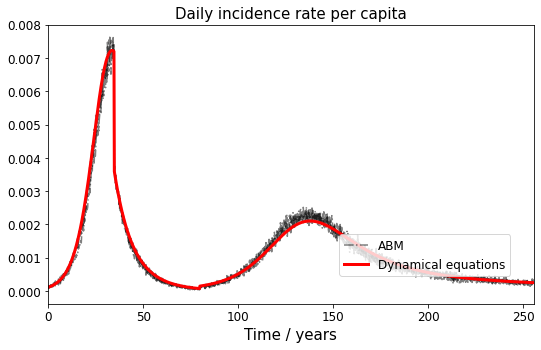

In [379]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

y11 = -np.diff(status_all[1, :]) / dt / 365

y11_s = (status_all_multipleSIM[:, 0, :]) / ntrials
y11_s = -np.diff(y11_s) / dt / 365
for count in range(NSIM):
    if count==0:
        axes2.plot(t[:-1]*365, y11_s[count,:], 'k-.', alpha=0.5, label='ABM')
    else:
        axes2.plot(t[:-1]*365, y11_s[count,:], 'k-.', alpha=0.5)
axes2.plot(t[:-1]*365, y11, 'r-',  lw=3, label='Dynamical equations')

axes2.legend(loc=(0.6, 0.1))
axes2.set_xlabel("Time / years")
axes2.set_title('Daily incidence rate per capita')
axes2.set_xlim([0,0.7*365])
#axes2.set_yscale('log')
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
#fig2.savefig("./figures/comparison_between_stochasticSIR&Fokker-Planck_"+str(mitigation_factor)+"mitigated_J.png", dpi=300)

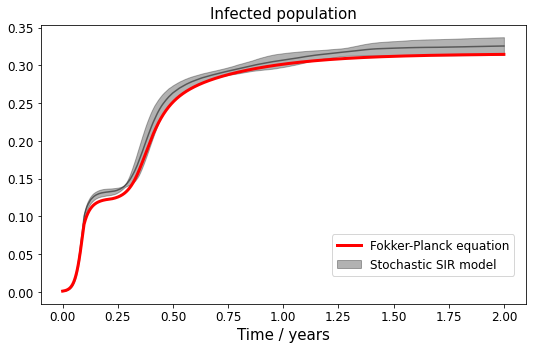

In [221]:
from scipy.stats import sem
y = (status_all_multipleSIM[:, 1, :] + status_all_multipleSIM[:, 2, :]) / ntrials
y = y[y[:,-1] > 0.1,: ]
y_est = np.mean(y, 0)
y_err = sem(y, 0)

fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

axes2.plot(t, y_est, 'k-', alpha=0.5)
axes2.fill_between(t, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='black', label='Stochastic SIR model')
axes2.plot(t, (1-status_all[1, :]), 'r-',  lw=3, label='Fokker-Planck equation')

axes2.legend(loc=(0.6, 0.1))
axes2.set_xlabel("Time / years")
axes2.set_title('Infected population')
#axes2.set_xlim([0,0.7])
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig2.savefig("./figures/comparison_between_stochasticSIR&Fokker-Planck_"+str(mitigation_factor)+"mitigated_infected_v2.png", dpi=300)

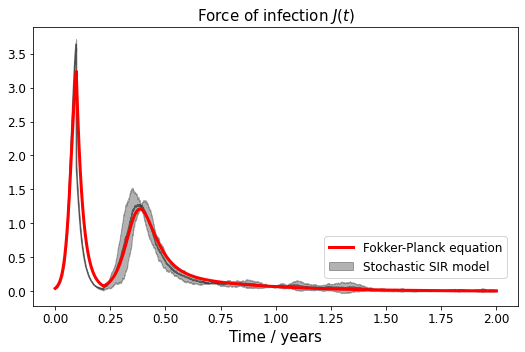

In [222]:
from scipy.stats import sem
y = status_all_multipleSIM[:, 3, :]
#y = y[y[:,-1] > 0.1,: ]
y_est = np.mean(y, 0)
y_err = sem(y, 0)

fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig2, axes2 = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

axes2.plot(t, y_est, 'k-', alpha=0.5)
axes2.fill_between(t, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='black', label='Stochastic SIR model')
axes2.plot(t, status_all[2, :], 'r-',  lw=3, label='Fokker-Planck equation')

axes2.legend(loc=(0.6, 0.1))
axes2.set_xlabel("Time / years")
axes2.set_title('Force of infection $J(t)$')
#axes2.set_yscale('log')
fig2.subplots_adjust(left=.1, bottom=.12, right=.97, top=.93, hspace=0.1)
fig2.savefig("./figures/comparison_between_stochasticSIR&Fokker-Planck_"+str(mitigation_factor)+"mitigated_J_v2.png", dpi=300)

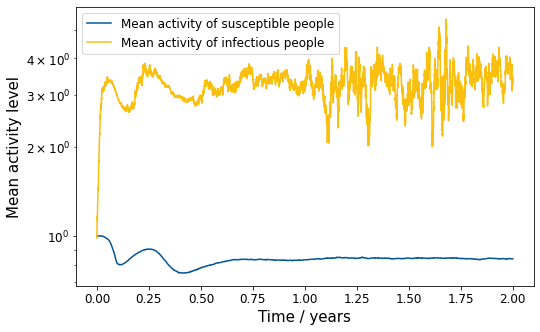

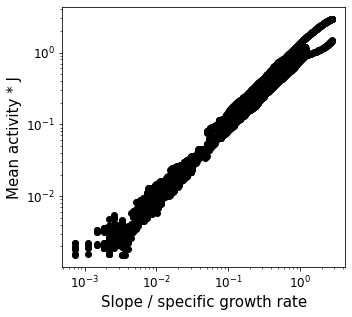

In [223]:
S = status_all_multipleSIM[0, 0, :] / ntrials
I = status_all_multipleSIM[0, 1, :] / ntrials
R = status_all_multipleSIM[0, 2, :] / ntrials
J = status_all_multipleSIM[0, 3, :]
activity_S = status_all_multipleSIM[0, 4, :]
activity_I = status_all_multipleSIM[0, 5, :]

fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(t, activity_S, label='Mean activity of susceptible people', color=color_list5[0])
axes.plot(t, activity_I, label='Mean activity of infectious people', color=color_list5[1])
axes.legend()
axes.set_yscale('log')
axes.set_xlabel("Time / years")
axes.set_ylabel('Mean activity level')
fig.subplots_adjust(left=.15, bottom=.12, right=.97, top=.93, hspace=0.1)
fig.savefig("./figures/mean_activity_levels.png", dpi=300)

x = np.diff(S) / S[1:] / dt
x = -pd.Series(x).rolling(int(5/365/dt)).mean()
y = J[1:]*activity_S[1:]
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(x, y, 'ko')
axes.plot([1e-2,1],[1e-2,1],'k-.')
axes.set_xlabel("Slope / specific growth rate")
axes.set_ylabel('Mean activity * J')
axes.set_aspect('equal')
axes.set_yscale('log')
axes.set_xscale('log')

## With mitigation

In [ ]:
#R0 = 2
ntrials = 1000000 #1000000
NSIM = 3 #10

start_day = 20; end_day = 80; mitigation_factor = 1.0
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)
y1_cum = status_all[1, :]
y1 = -np.diff(y1_cum) / dt / 365
status_all_multipleSIM = np.zeros((NSIM, 6, n))
for count in range(NSIM):
    status_all = stochastic_SIR(ntrials, mitigation_period, mitigation_factor_list)
    status_all_multipleSIM[count, :, :] = status_all
y1_cum_s = (status_all_multipleSIM[:, 0, :]) / ntrials
y1_s = -np.diff(y1_cum_s) / dt / 365

#start_day = 30; end_day = 45; mitigation_factor = 0.5
#start_day = 25; end_day = 40; mitigation_factor = 0.5
start_day = 27; end_day = 42; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)
y2_cum = status_all[1, :]
y2 = -np.diff(y2_cum) / dt / 365
status_all_multipleSIM = np.zeros((NSIM, 6, n))
for count in range(NSIM):
    status_all = stochastic_SIR(ntrials, mitigation_period, mitigation_factor_list)
    status_all_multipleSIM[count, :, :] = status_all
y2_cum_s = (status_all_multipleSIM[:, 0, :]) / ntrials
y2_s = -np.diff(y2_cum_s) / dt / 365

#start_day = 40; end_day = 85; mitigation_factor = 0.5
#start_day = 35; end_day = 80; mitigation_factor = 0.5
start_day = 37; end_day = 82; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)
y3_cum = status_all[1, :]
y3 = -np.diff(y3_cum) / dt / 365
status_all_multipleSIM = np.zeros((NSIM, 6, n))
for count in range(NSIM):
    status_all = stochastic_SIR(ntrials, mitigation_period, mitigation_factor_list)
    status_all_multipleSIM[count, :, :] = status_all
y3_cum_s = (status_all_multipleSIM[:, 0, :]) / ntrials
y3_s = -np.diff(y3_cum_s) / dt / 365

/Users/tongwang/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tongwang/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


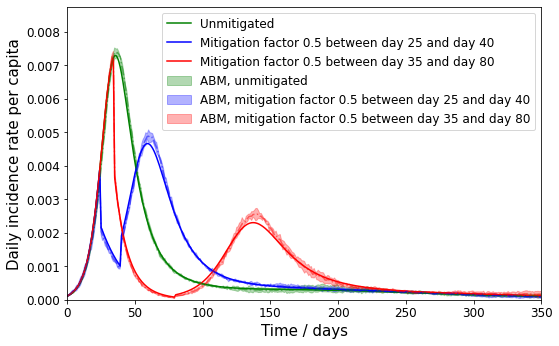

In [22]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*1]
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(t[:-1]*365, y1, 'g-', label='Unmitigated')
axes.plot(t[:-1]*365, y2, 'b-', label='Mitigation factor 0.5 between day 25 and day 40')
axes.plot(t[:-1]*365, y3, 'r-', label='Mitigation factor 0.5 between day 35 and day 80')

y_est = np.mean(y1_s, 0)
y_err = sem(y1_s, 0)
axes.plot(t[:-1]*365, y_est, 'g-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='g', label='ABM, unmitigated')

y_est = np.mean(y2_s, 0)
y_err = sem(y2_s, 0)
axes.plot(t[:-1]*365, y_est, 'b-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='b', label='ABM, mitigation factor 0.5 between day 25 and day 40')

y_est = np.mean(y3_s, 0)
y_err = sem(y3_s, 0)
axes.plot(t[:-1]*365, y_est, 'r-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM, mitigation factor 0.5 between day 35 and day 80')

axes.legend()
axes.set_xlim([0, 350])
axes.set_ylim([0, np.max(y1)*1.2])
#axes.set_yscale('log')
axes.set_xlabel("Time / days")
axes.set_ylabel('Daily incidence rate per capita')
fig.subplots_adjust(left=.12, bottom=.12, right=.97, top=.97, hspace=0.1)
#fig.savefig("./figures/Figure1B_2.5day_timeStep_v3.png", dpi=300)

In [16]:
#R0 = 2
ntrials = 1000000 #1000000
NSIM = 10 #10

start_day = 20; end_day = 80; mitigation_factor = 1.0
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)
y1_cum = status_all[1, :]
y1 = -np.diff(y1_cum) / dt / 365

start_day = 25; end_day = 40; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)
y2_cum = status_all[1, :]
y2 = -np.diff(y2_cum) / dt / 365

start_day = 35; end_day = 80; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
status_all = Fokker_Planck_SIR(mitigation_period, mitigation_factor_list)
y3_cum = status_all[1, :]
y3 = -np.diff(y3_cum) / dt / 365

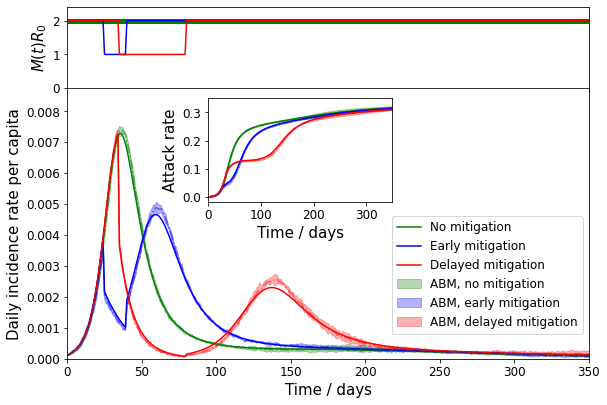

In [395]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0]*1.1, fig_dims[1]*1.2]
fig, ax = plt.subplots(2, 1, figsize=fig_dims, sharex=True, gridspec_kw={'height_ratios': [0.6, 2]})
axes = ax[1]
axes.plot(t[:-1]*365, y1, 'g-', label='No mitigation')
axes.plot(t[:-1]*365, y2, 'b-', label='Early mitigation')
axes.plot(t[:-1]*365, y3, 'r-', label='Delayed mitigation')

y_est = np.mean(y1_s, 0)
y_err = sem(y1_s, 0)
axes.plot(t[:-1]*365, y_est, 'g-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='g', label='ABM, no mitigation')

y_est = np.mean(y2_s, 0)
y_err = sem(y2_s, 0)
axes.plot(t[:-1]*365, y_est, 'b-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='b', label='ABM, early mitigation')

y_est = np.mean(y3_s, 0)
y_err = sem(y3_s, 0)
axes.plot(t[:-1]*365, y_est, 'r-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM, delayed mitigation')

axes.legend(bbox_to_anchor=(0.5, 0.05, 0.5, 0.5))
axes.set_xlim([0, 350])
axes.set_ylim([0, np.max(y1)*1.2])
#axes.set_yscale('log')
axes.set_xlabel("Time / days")
axes.set_ylabel('Daily incidence rate per capita')

axes = ax[0]
R0 = 2
start_day = 20; end_day = 80; mitigation_factor = 1.0
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
axes.plot(t*365, mitigation_factor_list*R0, 'g-', lw=5)
#axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM')

start_day = 25; end_day = 40; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
axes.plot(t*365, mitigation_factor_list*R0, 'b-')

start_day = 35; end_day = 80; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
axes.plot(t*365, mitigation_factor_list*R0, 'r-')
axes.set_ylabel('$M(t)R_0$')
axes.set_xlabel("Time / days")
axes.set_ylim([0, 2.4])

left, bottom, width, height = [0.35, 0.5, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
axes = ax2
axes.plot(t*365, 1-y1_cum, 'g-')
y_est = np.mean(1-y1_cum_s, 0)
y_err = sem(1-y1_cum_s, 0)
axes.plot(t*365, y_est, 'g-.', alpha=0.5)
axes.fill_between(t*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='g', label='ABM')

axes.plot(t*365, 1-y2_cum, 'b-')
y_est = np.mean(1-y2_cum_s, 0)
y_err = sem(1-y2_cum_s, 0)
axes.plot(t*365, y_est, 'b-.', alpha=0.5)
axes.fill_between(t*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='b', label='ABM')

axes.plot(t*365, 1-y3_cum, 'r-')
y_est = np.mean(1-y3_cum_s, 0)
y_err = sem(1-y3_cum_s, 0)
axes.plot(t*365, y_est, 'r-.', alpha=0.5)
axes.fill_between(t*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM')
axes.set_xlim([0, 350])
#axes.set_ylim([0, np.max(y1)*1.2])
axes.set_xlabel("Time / days")
axes.set_ylabel('Attack rate')

fig.subplots_adjust(left=.12, bottom=.12, right=.97, top=.97, hspace=0.0)
#fig.savefig("./figures/Figure1B_2.5day_timeStep_v4.png", dpi=300)

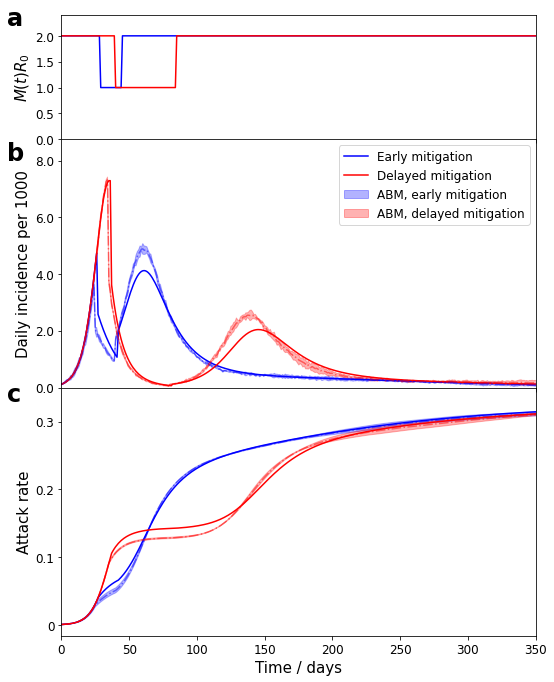

In [20]:
fig_dims = figure_size_setting(700)
fig_dims = [fig_dims[0], fig_dims[1]*2]
fig, ax = plt.subplots(3, 1, figsize=fig_dims, sharex=True, gridspec_kw={'height_ratios': [1.0, 2, 2]})

#left, bottom, width, height = [0.55, 0.65, 0.4, 0.3]
#ax2 = fig.add_axes([left, bottom, width, height])
axes = ax[0]
R0 = 2
start_day = 20; end_day = 80; mitigation_factor = 1.0
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
#axes.plot(t*365, mitigation_factor_list*R0, 'g-', lw=5)
#axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM')

#start_day = 25; end_day = 40; mitigation_factor = 0.5
start_day = 30; end_day = 45; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
axes.plot(t*365, mitigation_factor_list*R0, 'b-')

#start_day = 35; end_day = 80; mitigation_factor = 0.5
start_day = 40; end_day = 85; mitigation_factor = 0.5
mitigation_period = range(int(start_day/365/dt), int(end_day/365/dt))
mitigation_factor_list = mitigation_factor_profile_generator(start_day, end_day, mitigation_factor)
axes.plot(t*365, mitigation_factor_list*R0, 'r-')
axes.set_ylabel('$M(t)R_0$')
axes.set_xlabel("Time / days")
axes.set_ylim([0, 2.4])
axes.text(-40, 2.2, "a", size=24, fontweight='bold')

axes = ax[1]
#axes.plot(t[:-1]*365, y1, 'g-', label='No mitigation')
#axes.plot(t[:-1]*365, y2, 'b-', label='Mitigation factor 0.5 between day 25 and day 40')
#axes.plot(t[:-1]*365, y3, 'r-', label='Mitigation factor 0.5 between day 35 and day 80')
axes.plot(t[:-1]*365, y2, 'b-', label='Early mitigation')
axes.plot(t[:-1]*365, y3, 'r-', label='Delayed mitigation')

y_est = np.mean(y1_s, 0)
y_err = sem(y1_s, 0)
#axes.plot(t[:-1]*365, y_est, 'g-.', alpha=0.5)
#axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='g', label='ABM, no mitigation')

y_est = np.mean(y2_s, 0)
y_err = sem(y2_s, 0)
axes.plot(t[:-1]*365, y_est, 'b-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='b', label='ABM, early mitigation')

y_est = np.mean(y3_s, 0)
y_err = sem(y3_s, 0)
axes.plot(t[:-1]*365, y_est, 'r-.', alpha=0.5)
axes.fill_between(t[:-1]*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM, delayed mitigation')
axes.legend()
axes.set_xlim([0, 350])
axes.set_ylim([0, np.max(y1)*1.2])
axes.set_yticks([0, 0.002, 0.004, 0.006, 0.008])
axes.set_yticklabels(np.array([0, 0.002, 0.004, 0.006, 0.008])*1000)
#axes.set_yscale('log')
#axes.set_xlabel("Time / days")
#axes.set_ylabel('Daily incidence rate per capita')
axes.set_ylabel('Daily incidence per 1000')
axes.text(-40, 0.008, "b", size=24, fontweight='bold')

axes = ax[2]
#axes.plot(t*365, 1-y1_cum, 'g-')
y_est = np.mean(1-y1_cum_s, 0)
y_err = sem(1-y1_cum_s, 0)
#axes.plot(t*365, y_est, 'g-.', alpha=0.5)
#axes.fill_between(t*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='g', label='ABM')

axes.plot(t*365, 1-y2_cum, 'b-')
y_est = np.mean(1-y2_cum_s, 0)
y_err = sem(1-y2_cum_s, 0)
axes.plot(t*365, y_est, 'b-.', alpha=0.5)
axes.fill_between(t*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='b', label='ABM')

axes.plot(t*365, 1-y3_cum, 'r-')
y_est = np.mean(1-y3_cum_s, 0)
y_err = sem(1-y3_cum_s, 0)
axes.plot(t*365, y_est, 'r-.', alpha=0.5)
axes.fill_between(t*365, y_est - 2*y_err, y_est + 2*y_err, alpha=0.3, color='r', label='ABM')
axes.set_xlim([0, 350])
#axes.set_ylim([0, np.max(y1)*1.2])
axes.set_xlabel("Time / days")
axes.set_ylabel('Attack rate')
axes.set_yticks([0, 0.1, 0.2, 0.3])
axes.set_yticklabels([0, 0.1, 0.2, 0.3])
axes.text(-40, 0.33, "c", size=24, fontweight='bold')

fig.subplots_adjust(left=.12, bottom=.07, right=.97, top=.97, hspace=0.0)
#fig.savefig("./figures/Figure1B_2.5day_timeStep_v4.png", dpi=300)
#fig.savefig("./figures/saved_figures/Figure3.png", dpi=300)
#fig.savefig("./figures/saved_figures/Figure3.pdf", dpi=300)
#fig.savefig("./figures/saved_figures/Figure3.svg")

In [417]:
'''########### pickle all processed data which are useful for simulations
import pickle

pickle_out = open("persistent_heterogeneity.pickle","wb")
#pickle.dump([net, i_selfish, i_intake, names], pickle_out)
pickle.dump([t, y1_cum, y2_cum, y3_cum, y1_cum_s, y2_cum_s, y3_cum_s], pickle_out)
pickle_out.close()

#pickle_in = open("persistent_heterogeneity.pickle","rb")
#[t, y1_cum, y2_cum, y3_cum, y1_cum_s, y2_cum_s, y3_cum_s] = pickle.load(pickle_in)

import pickle
pickle_in = open("persistent_heterogeneity.pickle","rb")
[t, y1_cum, y2_cum, y3_cum, y1_cum_s, y2_cum_s, y3_cum_s] = pickle.load(pickle_in)
'''